In [17]:
import numpy as np
import torch
from PIL import Image, ImageDraw
from torch.utils import data
from torchvision.transforms import transforms
import math

from matplotlib.pyplot import imshow
%matplotlib inline

In [400]:
class RectangleDataset(data.Dataset):
    """Rectangle in black background"""

    IMG_SIZE = 320
    WIDTH = 130
    HEIGHT = 80
    MARGIN = math.sqrt((WIDTH / 2) ** 2 + (HEIGHT / 2) ** 2) + 50
    MAX_ANGLE = 45

    def __init__(self, count: int):
        volatility = self.IMG_SIZE - 2 * self.MARGIN
        x_center = np.random.randint(volatility, size=count) + self.MARGIN
        y_center = np.random.randint(volatility, size=count) + self.MARGIN
        angle = np.random.randint(self.MAX_ANGLE, size=count)
#         to_tensor = transforms.ToTensor()
        self.labels = [self.get_rectangle_coords(x_center[i], y_center[i], angle[i]) for i in range(count)]
        self.values = [
            self.generate_image(x_center[i], y_center[i], angle[i], self.labels[i]) for i in range(count)
        ]

    def generate_image(self, x: float, y: float, theta: int, coords: np.ndarray) -> Image:
        image = Image.new("RGB", (self.IMG_SIZE, self.IMG_SIZE))
        draw = ImageDraw.Draw(image)
        draw.rectangle([(0, 0), image.size], fill="black")
        draw.rectangle(self.rectangle_at_center, fill="white")
        image = image.rotate(theta, resample=Image.BILINEAR, expand=False)
        center = self.IMG_SIZE / 2
        image = self.shift_image(image, x - center, y - center)
        draw2 = ImageDraw.Draw(image)
        for point in coords:
            px = point.item(0, 0) #+ center
            py = point.item(0, 1) #+ center
            d = 10
            draw2.ellipse((px - d, py - d, px + d, py + d), fill="red")
        return image

    @property
    def rectangle_at_center(self):
        center = self.IMG_SIZE / 2
        return [
            (center - self.WIDTH / 2, center - self.HEIGHT / 2),
            (center + self.WIDTH / 2, center + self.HEIGHT / 2),
        ]

    @staticmethod
    def shift_image(img, shift_x, shift_y):
        return img.transform(img.size, Image.AFFINE, (1, 0, -shift_x, 0, 1, -shift_y))

    def get_rectangle_coords(self, x: int, y: int, theta: int) -> np.ndarray:
        theta_ = theta / 180.0 * np.pi
        center = self.IMG_SIZE / 2
        rotation_matrix = np.matrix(((np.cos(theta_), -np.sin(theta_)), (np.sin(theta_), np.cos(theta_))))
        coords = self.get_straight_rectangle_coords(0, 0) @ rotation_matrix
        coords[:, 0] = coords[:, 0] + x
        coords[:, 1] = coords[:, 1] + y
        return coords

    def get_straight_rectangle_coords(self, x: float, y: float) -> np.matrix:
        return np.matrix(
            (
                (x + self.WIDTH / 2, y + self.HEIGHT / 2),
                (x + self.WIDTH / 2, y - self.HEIGHT / 2),
                (x - self.WIDTH / 2, y + self.HEIGHT / 2),
                (x - self.WIDTH / 2, y - self.HEIGHT / 2),
            )
        )

    def __len__(self):
        return len(self.values)

    def __getitem__(self, index):
        """Generates one sample of data"""
        return self.values[index], self.labels[index]

matrix([[219.86510945, 141.94248555],
        [164.29243982,  84.39530152],
        [126.35093541, 232.24807371],
        [ 70.77826577, 174.70088968]])

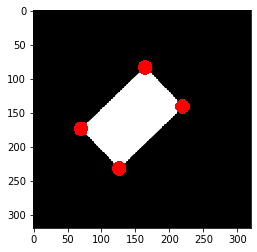

In [408]:
dataset = RectangleDataset(1)
imshow(np.asarray(dataset[0][0]));
dataset[0][1]